# Data Augmentation with clearbox-synthetic-kit

_by Simona Mazzarino ([Linkedin](https://www.linkedin.com/in/simona-mazzarino-3ba7b7225/),  [Github](https://github.com/simonamazzarino))_

In this notebook you will learn how to implement **Data Augmentation** using Synthetic Data generated with **clearbox-synthetic-kit** for an imbalanced dataset.

**Level**: Basic \
**Time to complete**: 15 minutes


------------------------------------------------------------------

## Install libraries

Install the library and the dataset. 

For this notebook we use a dataset of bank marketing data from the **UC Irvine Machine Learning Repository (ucimlrepo)**.

The UCI Machine Learning Repository is a collection of databases, domain theories, and data generators that are used by the machine learning community for the empirical analysis of machine learning algorithms.

🔷 You can explore it [here](https://archive.ics.uci.edu/).

In [61]:
# !pip install clearbox-synthetic-kit ucimlrepo

## Preprocessing and creation of a classification model

In this section we study the **bank_marketing** dataset and create a [XGBoost](https://xgboost.readthedocs.io/en/stable/index.html) model for a classification task.

The goal is to predict whether a client has subscribed a term deposit (feature _**y**_).

For more information about the dataset features, please refer to this [documentation](https://archive.ics.uci.edu/dataset/222/bank+marketing).


In [62]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from clearbox_synthetic.utils import Dataset, Preprocessor
from clearbox_synthetic.generation import TabularEngine, LabeledSynthesizer
from clearbox_synthetic.evaluation.privacy import PrivacyScore

In [63]:
from ucimlrepo import fetch_ucirepo
bank_marketing = fetch_ucirepo(id=222)
X = bank_marketing.data.features
y = bank_marketing.data.targets

df = pd.concat([X, y], axis=1)
df = df.sample(frac=1).reset_index(drop=True)
df

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,35,blue-collar,married,secondary,no,0,yes,yes,cellular,20,apr,123,3,-1,0,NaN,no
1,52,technician,married,tertiary,no,0,no,no,cellular,9,aug,145,3,94,4,success,no
2,37,services,married,secondary,no,3429,yes,yes,NaN,26,may,81,8,-1,0,NaN,no
3,36,blue-collar,divorced,secondary,no,64,no,no,cellular,8,jun,143,2,-1,0,NaN,no
4,43,management,single,tertiary,no,-2,no,yes,cellular,9,jul,124,1,-1,0,NaN,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,33,services,married,tertiary,no,546,yes,yes,NaN,9,may,253,1,-1,0,NaN,no
45207,49,management,single,tertiary,no,1,yes,no,NaN,6,jun,59,3,-1,0,NaN,no
45208,55,blue-collar,married,primary,no,158,yes,no,NaN,15,may,176,18,-1,0,NaN,no
45209,26,management,single,primary,no,71,no,no,NaN,17,jun,390,2,-1,0,NaN,no


In [64]:
print("Dataset -  rows:",df.shape[0]," columns:", df.shape[1])

Dataset -  rows: 45211  columns: 17


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [66]:
cat_feats = [i for i in df.columns if (df[i].dtype == 'object') | (df[i].dtype == 'bool')]
for col in cat_feats:
    df[col] = df[col].astype('category')

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   age          45211 non-null  int64   
 1   job          44923 non-null  category
 2   marital      45211 non-null  category
 3   education    43354 non-null  category
 4   default      45211 non-null  category
 5   balance      45211 non-null  int64   
 6   housing      45211 non-null  category
 7   loan         45211 non-null  category
 8   contact      32191 non-null  category
 9   day_of_week  45211 non-null  int64   
 10  month        45211 non-null  category
 11  duration     45211 non-null  int64   
 12  campaign     45211 non-null  int64   
 13  pdays        45211 non-null  int64   
 14  previous     45211 non-null  int64   
 15  poutcome     8252 non-null   category
 16  y            45211 non-null  category
dtypes: category(10), int64(7)
memory usage: 2.8 MB


Let's examine the distribution of the target variable 📊.

> It appears to be imbalanced, indicating that only a small portion of individuals in the dataset have subscribed to a term deposit.

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64


Text(0, 0.5, 'Frequency')

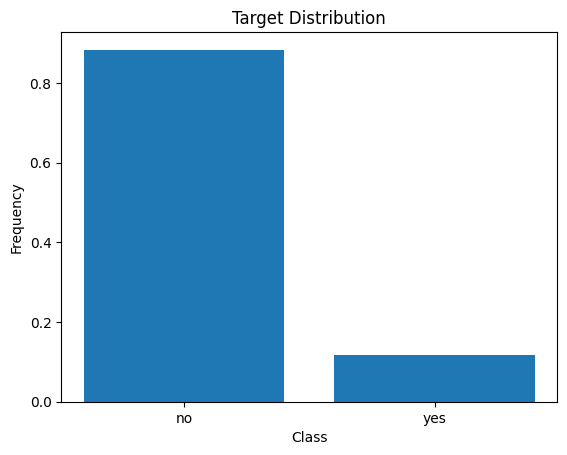

In [68]:
counts = df['y'].value_counts(normalize=True)
print(counts)
x = counts.index.astype(str)
y = counts.values

plt.bar(x, y)
plt.title('Target Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')

In [69]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

> Saving the datasets is necessary because evaluating the effectiveness of the data augmentation strategy requires testing on a consistent test set.

In [70]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [71]:
X_train = train.drop('y', axis=1)
y_train = train['y'].map({'yes': 1, 'no': 0})

In [72]:
X_test = test.drop('y', axis=1)
y_test = test['y'].map({'no': 0, 'yes': 1})

In [73]:
len(X_train), len(X_test)

(36168, 9043)

In [74]:
from xgboost import XGBClassifier
bst = XGBClassifier(n_estimators=10, max_depth=2, enable_categorical=True, learning_rate=1, objective='binary:logistic')
bst.fit(X_train, y_train)
preds = bst.predict(X_test)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7992
           1       0.61      0.44      0.51      1051

    accuracy                           0.90      9043
   macro avg       0.77      0.70      0.73      9043
weighted avg       0.89      0.90      0.89      9043



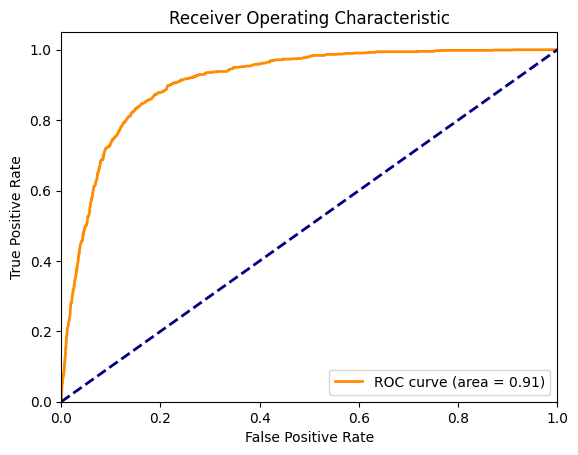

In [75]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(classification_report(y_test, preds))

fpr, tpr, thresholds = roc_curve(y_test, bst.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

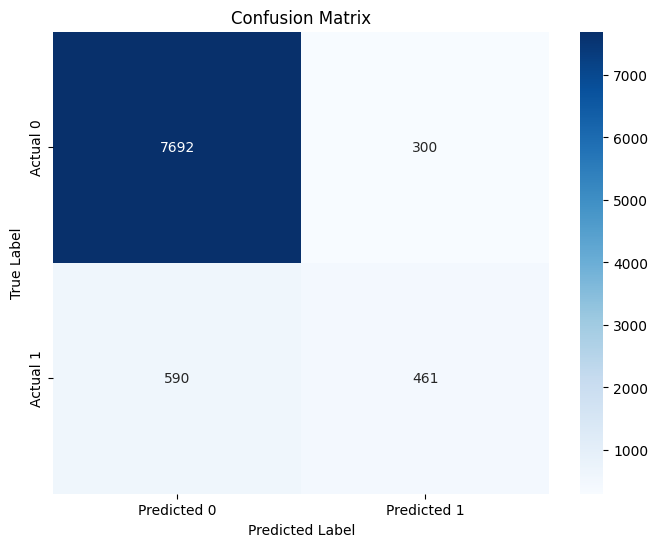

In [76]:
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

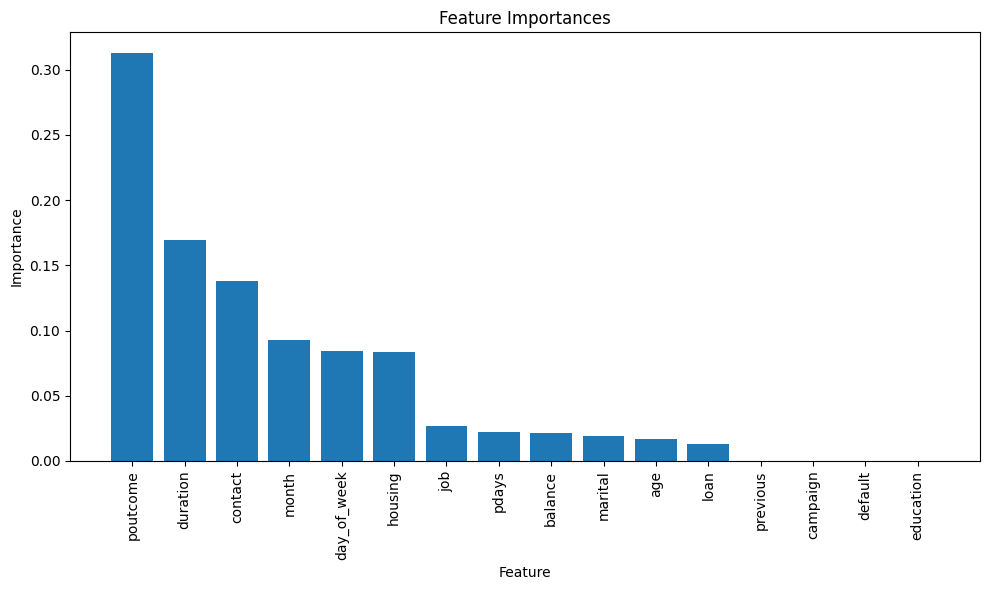

In [77]:
def plot_feature_importance(model, feature_names, top_n=None):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
        if importances.ndim > 1:
            importances = importances.mean(axis=0)
    else:
        raise ValueError("The provided model does not have feature_importances_ or coef_ attribute.")

    indices = np.argsort(importances)[::-1]
    if top_n is not None:
        indices = indices[:top_n]
        importances = importances[indices]
        feature_names = [feature_names[i] for i in indices]
    else:
        importances = importances[indices]
        feature_names = [feature_names[i] for i in indices]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances, align='center')
    plt.xticks(range(len(importances)), feature_names, rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

feature_names = df.columns.tolist()
plot_feature_importance(bst, feature_names)

## Let's create a synthetic dataset! 📑

To use `clearbox-synthetic-kit` to generate synthetic data, we first need to create a Dataset object with our train data.


The class `Dataset` in clearbox-synthetic-kit is a flexible class created to perform data manipulation.

📖 Read more [here](https://clearbox-synthetic-kit.readthedocs.io/en/latest/api/clearbox_synthetic.utils.dataset.html).

In [78]:
train_dataset = Dataset.from_csv(
        csv_file = 'train.csv',
        target_column="y",
        regression=False
    )

The `Preprocessor` is used to preprocess tabular (and time-series) data.

It includes functionality for encoding categorical variables, handling missing values, and feature selection.

> The ***threshold*** parameter controls how often a category must appear within a categorical column to be retained in the generation. If a category's frequency falls below this threshold, the preprocessor groups all such infrequent categories together into a single category labeled as '*'.

> The default threshold is 0.02

In [79]:
preprocessor = Preprocessor(train_dataset, threshold = 0.001)

# Preprocessing training dataset
X_train_raw = train_dataset.get_x() # Get all columns of the training dataset except the target column (y)
X_train = preprocessor.transform(X_train_raw)

In [80]:
y_train = train_dataset.get_one_hot_encoded_y()

The `TabularEngine` class integrates the TabularVAE and TabularDiffusion models to enable training, evaluation, and inference for tabular datasets.


It is the **synthetic data generator**.

> To improve the generation you can try different values for the following parameters:


*   `layer_size`
*   `epochs`
*   `learning_rate`



In [81]:
# Initialize the tabular synthetic data generator
engine = TabularEngine(
    layers_size=[50],
    x_shape=X_train[0].shape,
    y_shape=y_train[0].shape,
    numerical_feature_sizes=preprocessor.get_features_sizes()[0],
    categorical_feature_sizes=preprocessor.get_features_sizes()[1],

)


# Start the training of the tabular synthetic data generator
engine.fit(X_train, y_train_ds=y_train, epochs=20, learning_rate=0.001)

Engine fitting in progress: 100%|██████████| 20/20 [00:22<00:00,  1.11s/epoch, Train loss:=155.68373]


The `LabeledSynthesizer` is the class to generate synthetic labeled data. It leverages the pre-trained engine trained on the original data to create new synthetic samples.



> When using a custom preprocessor (such as when setting a different threshold), it must be explicitly passed as a parameter to the `LabeledSynthesizer`. Otherwise, the `LabeledSynthesizer` will use a default preprocessor that may not be compatible with the one used to train the engine, raising an error.



In [82]:
synthesizer = LabeledSynthesizer(train_dataset, engine, preprocessor)

In [ ]:
synthetic_dataset = synthesizer.generate(has_header=True)

synthetic_dataset.to_csv("synthetic_dataset.csv", index=False)

## Utility Assessment

The **utility** of synthetic data refers to its ability to retain the informative content and performance of the original dataset while ensuring privacy and scalability.

To evaluate utility, multiple metrics are used, including **Train on Synthetic-Test on Real (TSTR)** to measure predictive performance.

Additionally, **classifier-based detection scores** help determine how distinguishable synthetic data is from real data, ensuring that it remains realistic yet privacy-preserving. These evaluations ensure synthetic data is both useful and reliable for real-world applications.

In [84]:
synth = pd.read_csv("synthetic_dataset.csv")
synth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          36168 non-null  int64 
 1   job          36160 non-null  object
 2   marital      36168 non-null  object
 3   education    34430 non-null  object
 4   default      36168 non-null  object
 5   balance      36168 non-null  int64 
 6   housing      36168 non-null  object
 7   loan         36168 non-null  object
 8   contact      25736 non-null  object
 9   day_of_week  36168 non-null  int64 
 10  month        36168 non-null  object
 11  duration     36168 non-null  int64 
 12  campaign     36168 non-null  int64 
 13  pdays        36168 non-null  int64 
 14  previous     36168 non-null  int64 
 15  poutcome     6898 non-null   object
 16  y            36168 non-null  object
dtypes: int64(7), object(10)
memory usage: 4.7+ MB


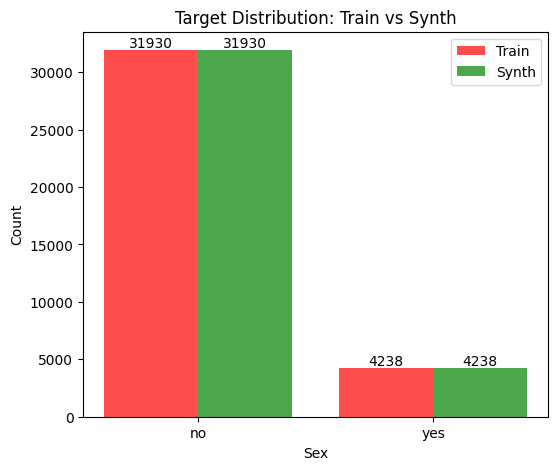

In [85]:
train_counts = train['y'].value_counts().sort_index()
synth_counts = synth['y'].value_counts().sort_index()
comparison_df = pd.DataFrame({'Train': train_counts, 'Synth': synth_counts}).fillna(0)
bar_width = 0.4
x = np.arange(len(comparison_df.index))  # Position for each category

plt.figure(figsize=(6, 5))
bars1 = plt.bar(x - bar_width/2, comparison_df['Train'], width=bar_width, label='Train', color='red', alpha=0.7)
bars2 = plt.bar(x + bar_width/2, comparison_df['Synth'], width=bar_width, label='Synth', color='green', alpha=0.7)

for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{int(bar.get_height())}',
             ha='center', va='bottom', fontsize=10, color='black')

for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{int(bar.get_height())}',
             ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel("Sex")
plt.ylabel("Count")
plt.title("Target Distribution: Train vs Synth")
plt.xticks(ticks=x, labels=comparison_df.index)
plt.legend()
plt.show()


In [86]:
synthetic_dataset = Dataset.from_csv(
        csv_file = 'synthetic_dataset.csv',
        target_column="y",
        regression=False
    )

### Detection Score

The `DetectionScore` class computes a detection score to evaluate the quality of a synthetic dataset by training a classifier to distinguish between original and synthetic data.

\
Ideally, the classifier should achieve around 50% accuracy, indicating that it cannot reliably differentiate between the two datasets, meaning the synthetic data is highly realistic while maintaining privacy.

In [87]:
from clearbox_synthetic.evaluation.utility import DetectionScore

detection_score = DetectionScore(
        train_dataset,
        synthetic_dataset,
        preprocessor
    ).get()

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:49:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Detection results:
  Accuracy:  0.5275
  ROC AUC:   0.5394
  Score:     0.9212


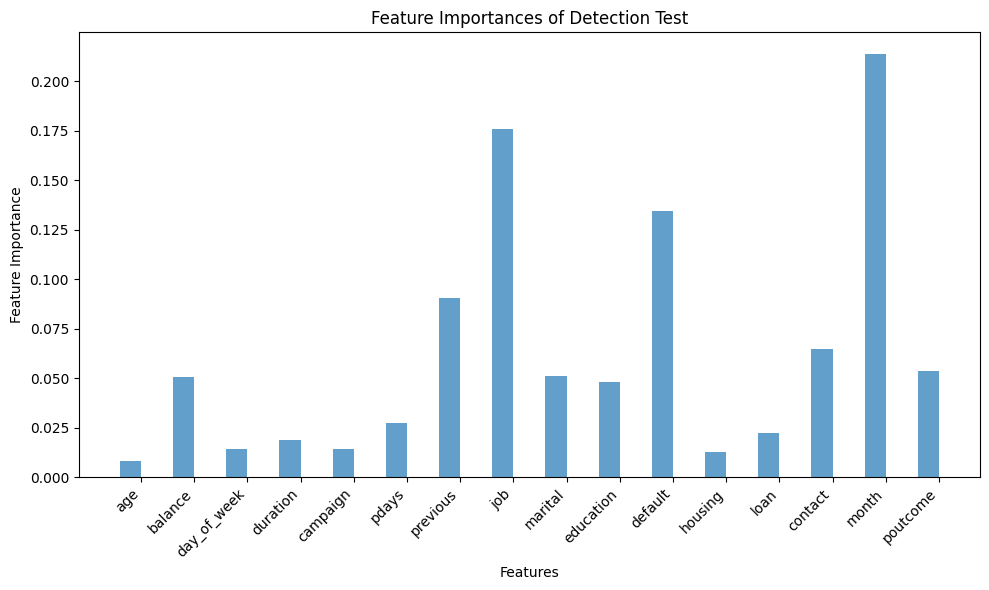

In [88]:
def display_detection_results(detection_score):
    print("Detection results:")
    print("  Accuracy: ", round(detection_score["accuracy"],4))
    print("  ROC AUC:  ", round(detection_score["ROC_AUC"],4))
    print("  Score:    ", round(detection_score["score"],4))

def plot_feature_importance_detection(detection_score):
    importances = detection_score["feature_importances"]

    features = list(importances.keys())
    values = np.array([importances[f] for f in features])

    x = np.arange(len(features))
    width = 0.4

    plt.figure(figsize=(10, 6))
    plt.bar(x - width / 2, values, width, alpha=0.7)

    plt.xticks(x, features, rotation=45, ha="right")
    plt.xlabel("Features")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importances of Detection Test")

    plt.tight_layout()
    plt.show()

display_detection_results(detection_score)
plot_feature_importance_detection(detection_score)

### TSTR Score

In [89]:
validation_dataset = Dataset.from_csv(
        csv_file = 'test.csv',
        target_column="y",
        regression=False
    )

The `TSTRScore` calculates the Train on Synthetic Test on Real (TSTR) score for both regression and classification tasks using XGBoost models. The class compares the performance of models trained on original and synthetic datasets.

> The higher the TSTRScore, the better the quality of synthetic data.

In [90]:
from clearbox_synthetic.evaluation.utility import TSTRScore

TSTR_score = TSTRScore(
        train_dataset,
        synthetic_dataset,
        validation_dataset,
        preprocessor
    ).get()

In [91]:
def display_TSTR(TSTR_score):
    # Extract metrics for training and synthetic into dataframes
    training_metrics = pd.DataFrame(TSTR_score['metrics']['training']).assign(Dataset='Training')
    training_metrics = training_metrics[["Dataset"] + [col for col in training_metrics.columns if col != "Dataset"]]

    synthetic_metrics = pd.DataFrame(TSTR_score['metrics']['synthetic']).assign(Dataset='Synthetic')
    synthetic_metrics = synthetic_metrics[["Dataset"] + [col for col in training_metrics.columns if col != "Dataset"]]

    # Combine both into a single table
    results_table = pd.concat([training_metrics, synthetic_metrics], ignore_index=True)

    # Add accuracy information to the table
    accuracy_table = pd.DataFrame([
        {'Dataset': 'Training', 'Accuracy': TSTR_score['accuracy']['training']},
        {'Dataset': 'Synthetic', 'Accuracy': TSTR_score['accuracy']['synthetic']}
    ])

    print("TSTR task: ", TSTR_score["task"])
    print("TSTR score: ", TSTR_score["score"])

    print("\n",accuracy_table.to_string(index=False))
    print("\n",results_table.to_string(index=False))

display_TSTR(TSTR_score)

TSTR task:  classification
TSTR score:  0.9972

   Dataset  Accuracy
 Training    0.9074
Synthetic    0.9102

   Dataset label  precision  recall  fscore  support
 Training    no     0.9351  0.9621  0.9484   7992.0
 Training   yes     0.6305  0.4919  0.5526   1051.0
Synthetic    no     0.9358  0.9646  0.9500   7992.0
Synthetic   yes     0.6484  0.4967  0.5625   1051.0


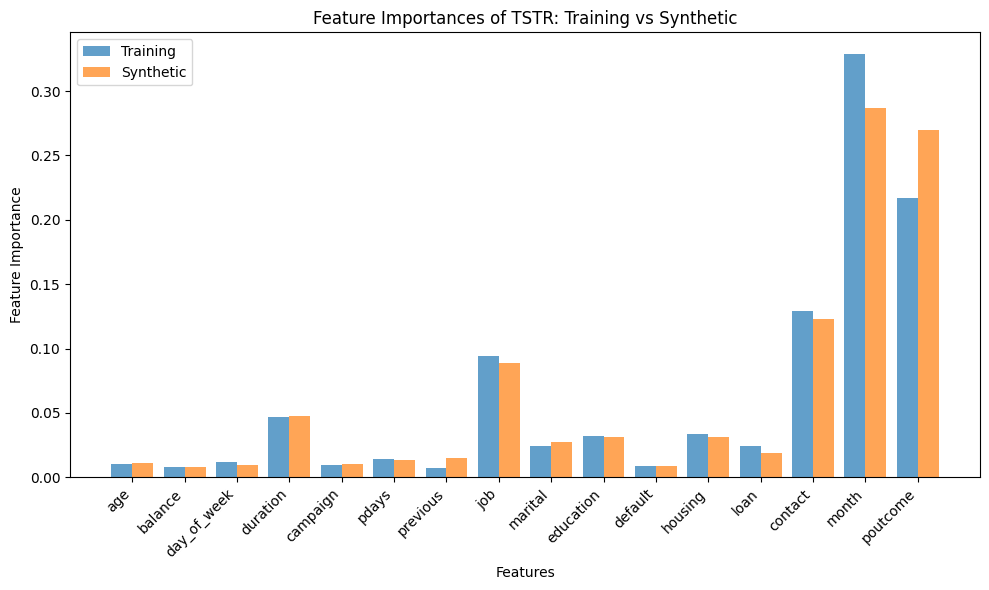

In [92]:
def plot_feature_importance_TSTR(TSTR_score):
    training_importances = TSTR_score["feature_importances"]["training"]
    synthetic_importances = TSTR_score["feature_importances"]["synthetic"]

    features = list(training_importances.keys())
    training_values = np.array([training_importances[f] for f in features])
    synthetic_values = np.array([synthetic_importances[f] for f in features])

    x = np.arange(len(features))
    width = 0.4

    plt.figure(figsize=(10, 6))
    plt.bar(x - width / 2, training_values, width, label="Training", alpha=0.7)
    plt.bar(x + width / 2, synthetic_values, width, label="Synthetic", alpha=0.7)

    plt.xticks(x, features, rotation=45, ha="right")
    plt.xlabel("Features")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importances of TSTR: Training vs Synthetic")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_feature_importance_TSTR(TSTR_score)

### Feature Comparison

The `FeaturesComparison` class compares the statistical properties of features between an original dataset and a synthetic dataset.

It provides detailed statistics for numerical, categorical, and datetime features.

In [93]:
from clearbox_synthetic.evaluation.utility import FeaturesComparison

fc = FeaturesComparison(
        train_dataset,
        synthetic_dataset,
        preprocessor
    ).get()

In [94]:
from typing import List

def display_feature_comparison(fc, features: List):
    for feature in features:
        if "values" in fc[feature].keys():
            fc[feature].pop("values")
        print("Feature: ", feature)
        print("-----------------------")
        print(pd.DataFrame(fc[feature]))
        print("\n===================================================================\n")

features = ["age", "marital", "job", "month", "poutcome"]
display_feature_comparison(fc, features)

Feature:  age
-----------------------
             type  na_values  unique_values     mean      std   min  \
training   number        0.0           77.0  40.9738  10.6521  18.0   
synthetic  number        0.0           76.0  40.9613  10.6185  18.0   

           first_quartile  second_quartile  third_quartile   max  
training             33.0             39.0            48.0  95.0  
synthetic            33.0             39.0            48.0  93.0  


Feature:  marital
-----------------------
                  type  na_values  unique_values
training   categorical        0.0            3.0
synthetic  categorical        0.0            3.0


Feature:  job
-----------------------
                  type  na_values  unique_values
training   categorical      230.0           11.0
synthetic  categorical        8.0           11.0


Feature:  month
-----------------------
                  type  na_values  unique_values
training   categorical        0.0           12.0
synthetic  categorical       

### Query Power

The `QueryPower` class assesses the quality of a synthetic dataset by running randomized queries that compare it to the original dataset. \
> The closer the query results are between both datasets, the higher the quality of the synthetic data.

In [95]:
from clearbox_synthetic.evaluation.utility import QueryPower

qp = QueryPower(train_dataset, synthetic_dataset, preprocessor).get()

print(f"Query Power score: {qp['score']}")
qp_df = pd.DataFrame(qp["queries"])
qp_df.rename(columns={"text": "Query"}, inplace=True)
qp_df

Query Power score: 0.9969


,Query,original_df,synthetic_df
0,`duration` >= 103.0 and `month` != 'mar',26822,26831
1,`default` != 'yes' and `loan` == 'yes',5529,5882
2,`age` <= 39.0 and `pdays` <= -1.0,15125,15127
3,`marital` != 'divorced' and `previous` <= 0.0,26186,25991
4,`day_of_week` >= 21.0 and `housing` == 'yes',5285,5277


## Privacy Assessment

The `PrivacyScore`class computes privacy metrics for original and synthetic datasets.



### Distance to Closest Record

One metric is the `Distance-To-Closest-Record (DCR)` that measures how closely a synthetic data point resembles the nearest real data point.

> A **large** DCR indicates that synthetic data points are sufficiently different from real ones, reducing the risk of re-identification and enhancing privacy. \
> A **small** DCR suggests potential privacy concerns, as synthetic records may be too similar to real ones.

By ensuring that synthetic data maintains a sufficient distance from real data while preserving utility, DCR helps balance privacy protection with data usability.

In [ ]:
privacy_metrics = PrivacyScore(
        train_dataset,
        synthetic_dataset,
        validation_dataset,
        parallel=True
    ).get(verbose = True)

In [97]:
training_metrics            = privacy_metrics['training_metrics']
synthetic_metrics           = privacy_metrics['synthetic_metrics']
synthetic_training_metrics  = privacy_metrics['synthetic_training_metrics']
synthetic_holdout_metrics   = privacy_metrics['synthetic_holdout_metrics']
membership_inference_test   = privacy_metrics['membership_inference_test']

            Duplicates stats
----------------------------------------
                    Training Synthetic
Duplicates                 0         0
Duplicates %           0.0 %     0.0 %
Unique duplicates          0         0
Unique duplicates %    0.0 %     0.0 %


Synthetic-Training clones: 44 (0.49 %)


                   DCR stats
----------------------------------------------
        Synthetic-Training   Synthetic-Holdout
mean               0.029398           0.035663
min                0.000000           0.000202
25%                0.004767           0.008993
median             0.014016           0.019092
75%                0.058841           0.065728
max                0.198298           0.271555


Synthetic-Training vs. Synthetic-Holdout Test (DCR share): 61.85 %


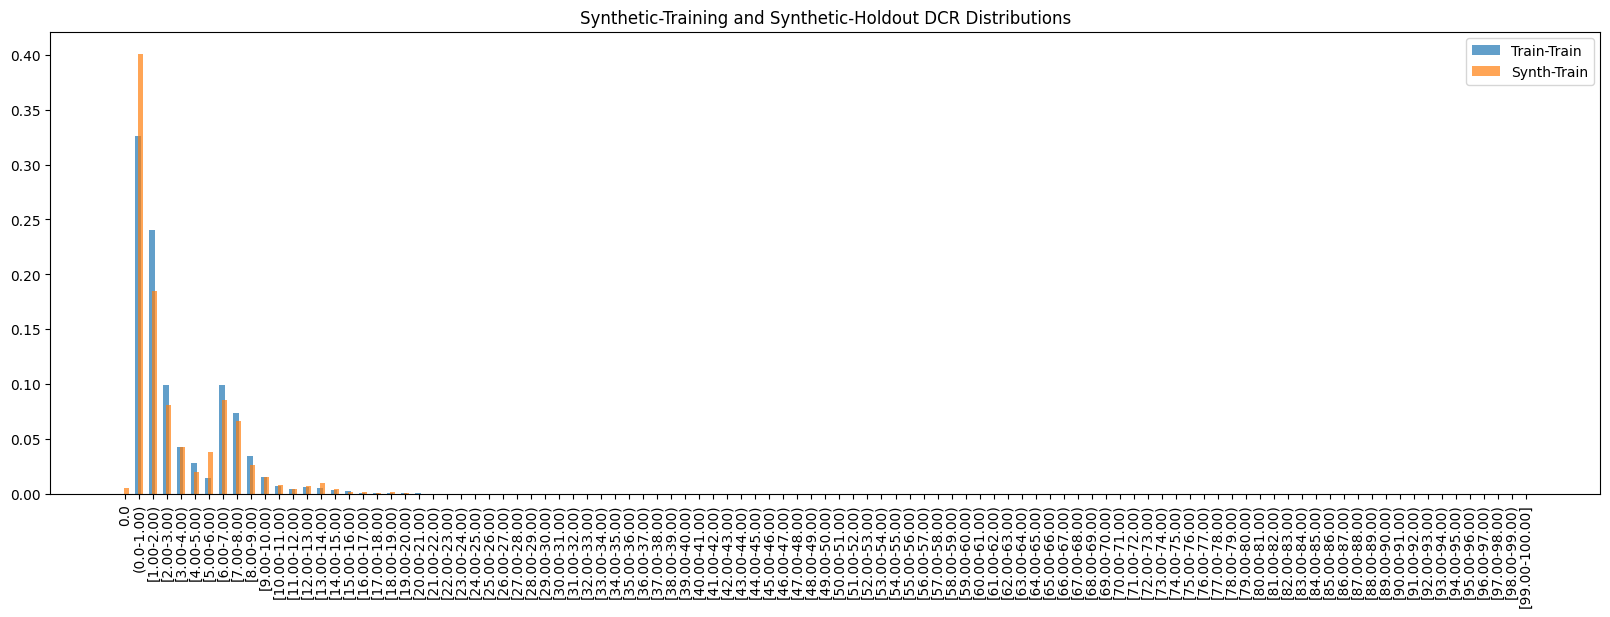

In [40]:
def display_DCR_results(training_metrics, synthetic_metrics, synthetic_training_metrics, synthetic_holdout_metrics):
    # Display useful DCR stats
    print("            Duplicates stats")
    print("----------------------------------------")
    print(pd.DataFrame({'Training':[f"{training_metrics['training_duplicates']}", f"{round(training_metrics['training_duplicates_percentage'],2)} %", f"{training_metrics['training_unique_duplicates']}", f"{round(training_metrics['training_unique_duplicates_percentage'],2)} %"],
                        'Synthetic':[f"{synthetic_metrics['synthetic_duplicates']}", f"{round(synthetic_metrics['synthetic_duplicates_percentage'],2)} %", f"{synthetic_metrics['synthetic_unique_duplicates']}", f"{round(synthetic_metrics['synthetic_unique_duplicates_percentage'],2)} %"]},
                        index=["Duplicates", "Duplicates %", "Unique duplicates", "Unique duplicates %"]))


    print(f"\n\nSynthetic-Training clones: {synthetic_training_metrics['synth_train_clones']} ({synthetic_training_metrics['synth_train_clones_percentage']:.2f} %)")

    print("\n\n                   DCR stats")
    print("----------------------------------------------")
    print(pd.DataFrame({'Synthetic-Training ': synthetic_training_metrics['dcr_synth_train_stats'], 'Synthetic-Holdout': synthetic_holdout_metrics['dcr_synth_holdout_stats']}))

    print("\n\nSynthetic-Training vs. Synthetic-Holdout Test (DCR share): {:.2f} %".format(synthetic_holdout_metrics['synth_holdout_test']))

def plot_DCR_results(training_metrics, synthetic_training_metrics):
    # Plot DCR synth-train and synth-holdout histograms
    labels = training_metrics['dcr_train_train_hist']['bins']
    train_train_counts = training_metrics['dcr_train_train_hist']['counts'] / np.sum(training_metrics['dcr_train_train_hist']['counts'])
    synth_train_counts = synthetic_training_metrics['dcr_synth_train_hist']['counts'] / np.sum(synthetic_training_metrics['dcr_synth_train_hist']['counts'])
    X_axis = np.arange(len(labels))
    plt.figure(figsize=(20,6))
    plt.xticks(X_axis, labels, rotation='vertical')
    plt.bar(X_axis-0.1, train_train_counts, 0.4, label = 'Train-Train', alpha=0.7)
    plt.bar(X_axis+0.1, synth_train_counts, 0.4, label = 'Synth-Train', alpha=0.7)
    plt.legend()
    plt.title("Synthetic-Training and Synthetic-Holdout DCR Distributions")

display_DCR_results(training_metrics, synthetic_metrics, synthetic_training_metrics, synthetic_holdout_metrics)
plot_DCR_results(training_metrics, synthetic_training_metrics)

### Membership Inference Attack (MIA)

A `Membership Inference Attack (MIA)` occurs when an attacker tries to determine if a specific record was in the training dataset used to generate synthetic data. This poses a privacy risk, especially if synthetic records closely resemble real ones.

The `PrivacyScore` class also comducts a **Membership Inference Test** (using the method `membership_inference_test()`) to estimate the risk of revealing membership information based on the distance between the adversary dataset and the synthetic dataset.

\
The function calculates the Distance to the Closest Record (DCR) between the adversary dataset and the synthetic dataset, applies various distance thresholds, and computes precision scores to evaluate the risk of membership inference.

In [41]:
print("Membership Inference Test")
print("  Adversary Distance Thresholds: {}".format(membership_inference_test['adversary_distance_thresholds']))
print("  Adversary Precision Score: {}".format(membership_inference_test['adversary_precisions']))
print("  Membership Inference Mean Risk Score: {:.4f}".format(membership_inference_test['membership_inference_mean_risk_score']))

Membership Inference Test
  Adversary Distance Thresholds: [0.01443079300224781, 0.00664421112742275, 0.0056153289042413235, 3.480229224805953e-06]
  Adversary Precision Score: [0.5348451327433629, 0.6371681415929203, 0.6957123098201936, 1.0]
  Membership Inference Mean Risk Score: 0.4339


## Data Augmentation with Synthetic Data

Let's import the generated synthetic data and consider only the rows of the minority class (class = yes)

In [100]:
synthetic_dataset = pd.read_csv("synthetic_dataset.csv")
df_train_original = pd.read_csv("train.csv")

In [101]:
synth_minority = synthetic_dataset[synthetic_dataset['y'] == "yes"]

Augment the original dataset with the synthetic data rows of the minority class.

In [102]:
df_train_aug = pd.concat([df_train_original, synth_minority]).sample(frac=1).reset_index(drop=True)
df_train_aug

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,52,technician,divorced,secondary,no,935,no,no,NaN,1,jul,86,1,-1,0,NaN,no
1,26,unemployed,single,tertiary,no,2170,no,no,cellular,3,feb,317,1,-1,0,NaN,no
2,25,technician,single,tertiary,no,1257,no,no,cellular,31,aug,271,2,-1,0,NaN,yes
3,30,technician,single,secondary,no,3313,yes,no,telephone,20,apr,534,3,319,3,failure,no
4,37,management,married,secondary,no,565,no,no,cellular,5,may,329,1,6,2,success,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40401,47,technician,married,tertiary,no,151,yes,no,NaN,5,may,190,1,-1,0,NaN,no
40402,35,management,married,tertiary,no,2583,no,no,cellular,19,nov,210,1,-1,0,NaN,no
40403,39,services,married,secondary,no,1205,yes,no,NaN,6,may,118,2,-1,0,NaN,no
40404,31,housemaid,married,secondary,no,12,yes,no,cellular,10,jul,81,3,-1,0,NaN,no


In [103]:
cat_feats = [i for i in df_train_aug.columns if (df_train_aug[i].dtype == 'object') | (df_train_aug[i].dtype == 'bool')]
for col in cat_feats:
    df_train_aug[col] = df_train_aug[col].astype('category')

Even though the classification problem remains imbalanced, we increase the number of samples for the minority class.

y
no     0.882825
yes    0.117175
Name: proportion, dtype: float64
y
no     0.790229
yes    0.209771
Name: proportion, dtype: float64


Text(0, 0.5, 'Frequency')

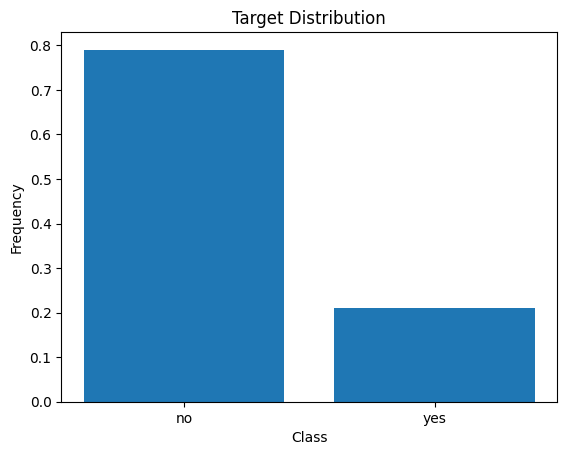

In [104]:
counts = df_train_original['y'].value_counts(normalize=True)
counts_aug = df_train_aug['y'].value_counts(normalize=True)
print(counts)
print(counts_aug)
x = counts_aug.index.astype(str)
y = counts_aug.values

plt.bar(x, y)
plt.title('Target Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')

In [105]:
X_train = df_train_aug.drop('y', axis=1)
y_train = df_train_aug['y'].map({'yes': 1, 'no': 0})

Let's import the same test_set used for the previous model

In [106]:
df_test_holdout = pd.read_csv("test.csv")

In [107]:
cat_feats = [i for i in df_test_holdout.columns if (df_test_holdout[i].dtype == 'object') | (df_test_holdout[i].dtype == 'bool')]
for col in cat_feats:
    df_test_holdout[col] = df_test_holdout[col].astype('category')

In [108]:
X_test = df_test_holdout.drop('y', axis=1)
y_test = df_test_holdout['y'].map({'no': 0, 'yes': 1})

In [109]:
len(X_train), len(X_test)

(40406, 9043)

In [110]:
bst_aug = XGBClassifier(n_estimators=10, max_depth=2, enable_categorical=True, learning_rate=1, objective='binary:logistic')
bst_aug.fit(X_train, y_train)
preds_aug = bst_aug.predict(X_test)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7992
           1       0.53      0.64      0.58      1051

    accuracy                           0.89      9043
   macro avg       0.74      0.78      0.76      9043
weighted avg       0.90      0.89      0.90      9043



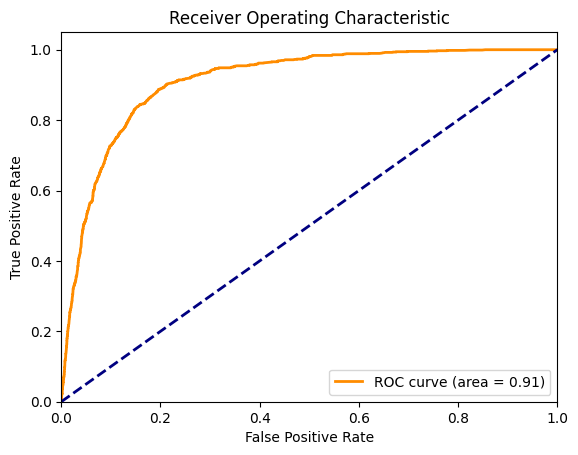

In [111]:
print(classification_report(y_test, preds_aug))
fpr, tpr, thresholds = roc_curve(y_test, bst_aug.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

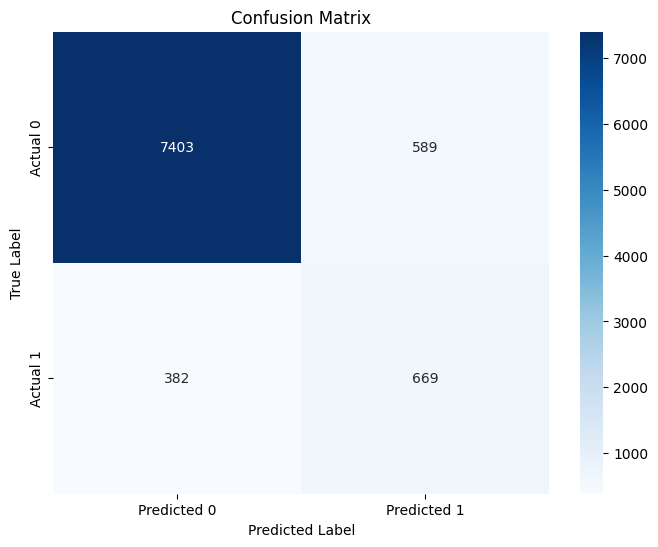

In [112]:
cm = confusion_matrix(y_test, preds_aug)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

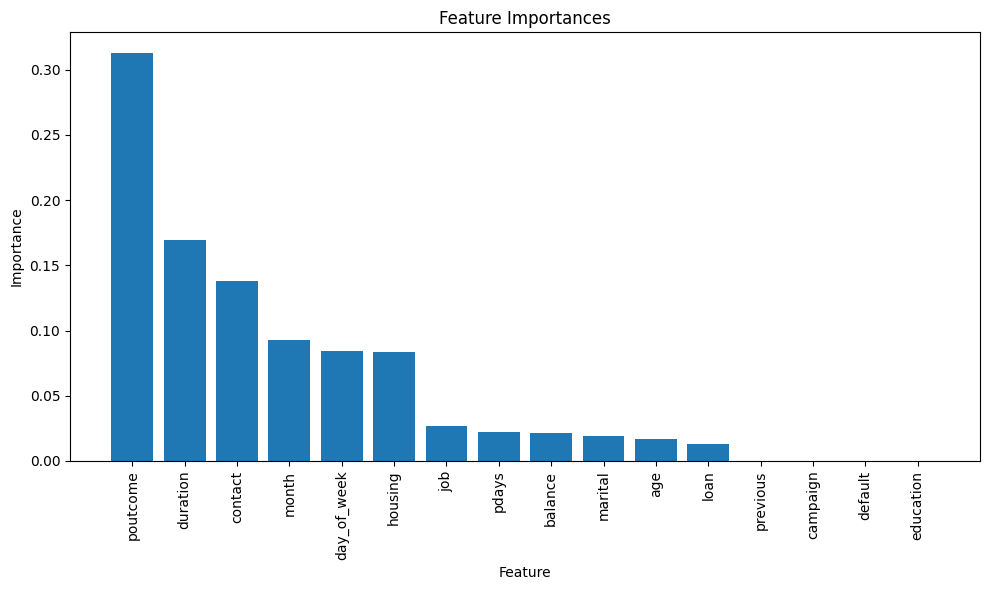

In [113]:
def plot_feature_importance(model, feature_names, top_n=None):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # For linear models, use absolute values. If multi-dimensional, average them.
        importances = np.abs(model.coef_)
        if importances.ndim > 1:
            importances = importances.mean(axis=0)
    else:
        raise ValueError("The provided model does not have feature_importances_ or coef_ attribute.")

    # Sort the feature importances in descending order.
    indices = np.argsort(importances)[::-1]

    # Optionally select only the top_n features.
    if top_n is not None:
        indices = indices[:top_n]
        importances = importances[indices]
        feature_names = [feature_names[i] for i in indices]
    else:
        importances = importances[indices]
        feature_names = [feature_names[i] for i in indices]

    # Plot the feature importances.
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances, align='center')
    plt.xticks(range(len(importances)), feature_names, rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

feature_names = df.columns.tolist()
plot_feature_importance(bst, feature_names)

## Results Comparison

Despite the **ROC curve** showing little to no improvement (or only a slight change), the recall for the minority class, along with the F1 score, experiences a significant boost.

This enhancement is crucial in imbalanced classification problems, where the minority class is often underrepresented and harder to detect.

\
A **higher recall** ensures that more **actual positive** cases are correctly identified, reducing false negatives (this is particularly vital in high-stakes applications like fraud detection or medical diagnosis, where missing a positive instance can have serious consequences).

By increasing recall, the model becomes more robust and reliable, effectively mitigating the challenges of class imbalance and improving overall predictive performance.

In [117]:
print("Classification Report for model trained on ORIGINAL dataset")
print(classification_report(y_test, preds))
print("-------------------------------------")
print("Classification Report for model trained on AUGMENTED dataset")
print(classification_report(y_test, preds_aug))

Classification Report for model trained on ORIGINAL dataset
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7992
           1       0.61      0.44      0.51      1051

    accuracy                           0.90      9043
   macro avg       0.77      0.70      0.73      9043
weighted avg       0.89      0.90      0.89      9043

-------------------------------------
Classification Report for model trained on AUGMENTED dataset
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7992
           1       0.53      0.64      0.58      1051

    accuracy                           0.89      9043
   macro avg       0.74      0.78      0.76      9043
weighted avg       0.90      0.89      0.90      9043



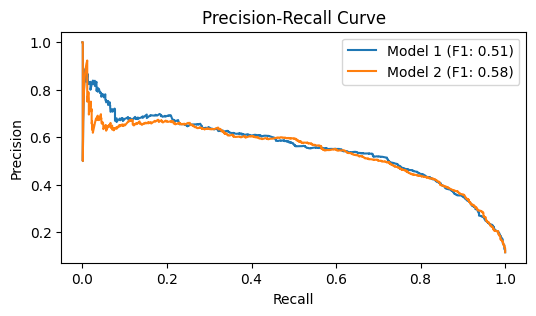

--------------------------------------------------


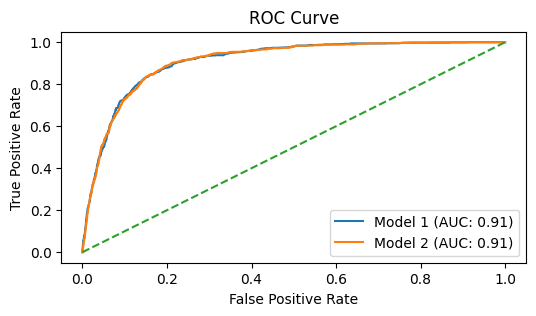

In [114]:
from sklearn.metrics import precision_recall_curve, f1_score

precision1, recall1, thresholds1 = precision_recall_curve(y_test, bst.predict_proba(X_test)[:, 1])
f1_score1 = f1_score(y_test, preds)

precision2, recall2, thresholds2 = precision_recall_curve(y_test, bst_aug.predict_proba(X_test)[:, 1])
f1_score2 = f1_score(y_test, preds_aug)

plt.figure(figsize=(6, 3))
plt.plot(recall1, precision1, label=f'Model 1 (F1: {f1_score1:.2f})')
plt.plot(recall2, precision2, label=f'Model 2 (F1: {f1_score2:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

print ("--------------------------------------------------")

# --- ROC Curve ---
fpr1, tpr1, thresholds1 = roc_curve(y_test, bst.predict_proba(X_test)[:, 1])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, thresholds2 = roc_curve(y_test, bst_aug.predict_proba(X_test)[:, 1])
roc_auc2 = auc(fpr2, tpr2)

plt.figure(figsize=(6, 3))
plt.plot(fpr1, tpr1, label=f'Model 1 (AUC: {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, label=f'Model 2 (AUC: {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
